In [1]:
import sys
sys.path.append("../../")
from simulation_classes.flying_cars import FlyingCars
from simulation_classes.simulation_periodic import SimulationPeriodic
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd


In [3]:
"""
シミュレーションの基本的な設定
基本的には ./periodic_simulation.ipynbを参考にしている。
DRONE_NUMについてfor文を回すためのファイル
"""

TOTAL_TIME = 100
time_step = 0.2
simulation_steps = int(TOTAL_TIME / time_step)
scale_factor = 20
legal_speed = 1.5
real_legal_speed = min(2, legal_speed) * scale_factor * 3.6
TOTAL_DISTANCE = 100
boundary_condition = "PERIODIC"
UPDATE_RULE = "parallel"
MAX_ACC_REAL_WORLD = 2 # 0.2Gくらい
MIN_ACC_REAL_WORLD = 5 # 0.5Gくらい

# 先頭の車が前になるように置く(一番後ろの車はx=0でスタート)
def scatter_cars_around(total_distance, car_num, idx, should_scatter=False):
    delta = total_distance / car_num
    return total_distance - delta * (idx+1)

result_obj = {}

min_headway = 10 # 一番密度が高い時の車間距離を [m] で設定
drone_num_for_max_density = int(TOTAL_DISTANCE * scale_factor / min_headway) #その時のドローン台数
print(f"最大ドローン台数：{drone_num_for_max_density}台")
increment = 5

最大ドローン台数：200台


### ここからシミュレーション開始。

In [4]:
max_acc = MAX_ACC_REAL_WORLD / scale_factor # ルンゲクッタの時に加速度にdelta_tがかかることに注意
min_acc = MIN_ACC_REAL_WORLD / scale_factor

helly_params = {
    "max_accel": max_acc,
    "min_accel": min_acc,
    "lambda_1": 0.2,
    "lambda_2": 0.4,
    "d": 0.482,
    "T_des": 1,
    "isRss":False
  }

simulation_list = []

for i in range(int(drone_num_for_max_density / increment)):
    DRONE_NUM = (i+1) * increment
    if (DRONE_NUM >206):
        break
    cars_list = [FlyingCars(xcor=scatter_cars_around(TOTAL_DISTANCE, DRONE_NUM, i),
                     ycor=0, 
                     v_0=0,
                     legal_speed=legal_speed, 
                     scale_factor=scale_factor,
                     drone_idx = i,
                     helly_params=helly_params,
                     )
               for i in range(DRONE_NUM)]
    print(DRONE_NUM)
    simulation = SimulationPeriodic(
        TOTAL_TIME=TOTAL_TIME, 
        time_step=time_step, 
        scale_factor=scale_factor,
        drone_list=cars_list,
        TOTAL_DISTANCE=TOTAL_DISTANCE,
        UPDATE_RULE=UPDATE_RULE )
    simulation.run()
    simulation_list.append(simulation)

    

5
===PARALLEL実行===
FINISHED
10
===PARALLEL実行===
FINISHED
15
===PARALLEL実行===
FINISHED
20
===PARALLEL実行===
FINISHED
25
===PARALLEL実行===
FINISHED
30
===PARALLEL実行===
FINISHED
35
===PARALLEL実行===
FINISHED
40
===PARALLEL実行===
FINISHED
45
===PARALLEL実行===
FINISHED
50
===PARALLEL実行===
FINISHED
55
===PARALLEL実行===
FINISHED
60
===PARALLEL実行===
FINISHED
65
===PARALLEL実行===
FINISHED
70
===PARALLEL実行===
FINISHED
75
===PARALLEL実行===
FINISHED
80
===PARALLEL実行===
FINISHED
85
===PARALLEL実行===
FINISHED
90
===PARALLEL実行===
FINISHED
95
===PARALLEL実行===
FINISHED
100
===PARALLEL実行===
FINISHED
105
===PARALLEL実行===
FINISHED
110
===PARALLEL実行===
FINISHED
115
===PARALLEL実行===
FINISHED
120
===PARALLEL実行===
FINISHED
125
===PARALLEL実行===
FINISHED
130
===PARALLEL実行===
FINISHED
135
===PARALLEL実行===
FINISHED
140
===PARALLEL実行===
FINISHED
145
===PARALLEL実行===
FINISHED
150
===PARALLEL実行===
FINISHED
155
===PARALLEL実行===
FINISHED
160
===PARALLEL実行===
FINISHED
165
===PARALLEL実行===
FINISHED
170
===PARALLEL実行===
FINISHED


### ここからは解析に入る

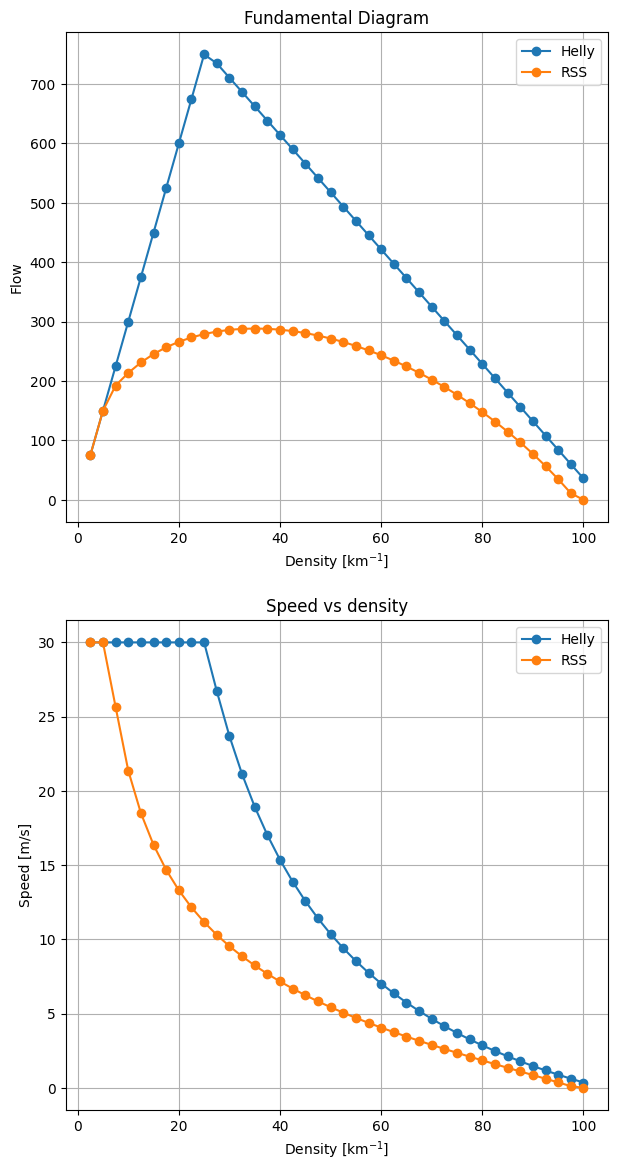

    density        flow  mean_velocity start_position  drone_num  model
0       2.5   75.000000      30.000000    unscattered          5  Helly
1       5.0  150.000000      30.000000    unscattered         10  Helly
2       7.5  225.000000      30.000000    unscattered         15  Helly
3      10.0  300.000000      30.000000    unscattered         20  Helly
4      12.5  375.000000      30.000000    unscattered         25  Helly
5      15.0  450.000000      30.000000    unscattered         30  Helly
6      17.5  525.000000      30.000000    unscattered         35  Helly
7      20.0  600.000000      30.000000    unscattered         40  Helly
8      22.5  675.000000      30.000000    unscattered         45  Helly
9      25.0  750.000000      30.000000    unscattered         50  Helly
10     27.5  734.890287      26.723283    unscattered         55  Helly
11     30.0  710.799824      23.693327    unscattered         60  Helly
12     32.5  686.702668      21.129313    unscattered         65

In [16]:
import pandas as pd

dataList = []
for simulation in simulation_list:
    cars = simulation.drone_list
    # 流量を計算する
    velocity_list = []
    for car in cars:
        snap_frame = int(simulation_steps * 0.95)
        velocity_list.append(car.v_xList[snap_frame])
    mean_velocity = np.mean(np.array(velocity_list)) * scale_factor

    # 密度：1km当たりの台数
    rho = len(cars) / (TOTAL_DISTANCE * scale_factor)  * 1000
    flow = rho * mean_velocity

    # プロット用に保存
    dataToSave = {
        "density":rho,
        "flow":flow,
        "mean_velocity":mean_velocity,
        "start_position":"unscattered",
        "drone_num":len(cars),
        "model":"Helly"
    }
    dataList.append(dataToSave)

df = pd.DataFrame(dataList)

# 折れ線グラフを描画
plt.figure(figsize=(7, 14))
plt.subplot(2, 1, 1)
plt.plot(df["density"], df["flow"], marker='o', label="Helly")
plt.plot(df_rss["density"], df_rss["flow"], marker='o', label="RSS")
plt.xlabel(r'Density [km$^{-1}$]')
plt.ylabel('Flow')
plt.title('Fundamental Diagram')
plt.grid(True)
plt.legend()


plt.subplot(2, 1, 2)
plt.plot(df["density"], df["mean_velocity"], marker='o', label="Helly")
plt.plot(df_rss["density"], df_rss["mean_velocity"], marker='o', label="RSS")
plt.xlabel(r'Density [km$^{-1}$]')
plt.ylabel('Speed [m/s]')
plt.title('Speed vs density')
plt.grid(True)
plt.legend()
plt.show()

print(df.head(20))
print(df_rss.head(20))

In [5]:
max_acc = MAX_ACC_REAL_WORLD / scale_factor # ルンゲクッタの時に加速度にdelta_tがかかることに注意
min_acc = MIN_ACC_REAL_WORLD / scale_factor

helly_params = {
    "max_accel": max_acc,
    "min_accel": min_acc,
    "lambda_1": 0.6,
    "lambda_2": 0.4,
    "d": 0.482,
    "T_des": 1,
    "isRss":True
  }

simulation_rss_list = []

for i in range(int(drone_num_for_max_density / increment)):
    DRONE_NUM = (i+1) * increment
    if (DRONE_NUM >206):
        break
    cars_list = [FlyingCars(xcor=scatter_cars_around(TOTAL_DISTANCE, DRONE_NUM, i),
                     ycor=0, 
                     v_0=0,
                     legal_speed=legal_speed, 
                     scale_factor=scale_factor,
                     drone_idx = i,
                     helly_params=helly_params,
                     )
               for i in range(DRONE_NUM)]
    print(DRONE_NUM)
    simulation = SimulationPeriodic(
        TOTAL_TIME=TOTAL_TIME, 
        time_step=time_step, 
        scale_factor=scale_factor,
        drone_list=cars_list,
        TOTAL_DISTANCE=TOTAL_DISTANCE,
        UPDATE_RULE=UPDATE_RULE )
    simulation.run()
    simulation_rss_list.append(simulation)

# ここからはデータの格納

dataList_rss = []
for simulation in simulation_rss_list:
    cars = simulation.drone_list
    # 流量を計算する
    velocity_list = []
    for car in cars:
        snap_frame = int(simulation_steps * 0.95)
        velocity_list.append(car.v_xList[snap_frame])
    mean_velocity = np.mean(np.array(velocity_list)) * scale_factor

    # 密度：1km当たりの台数
    rho = len(cars) / (TOTAL_DISTANCE * scale_factor)  * 1000
    flow = rho * mean_velocity

    # プロット用に保存
    dataToSave = {
        "density":rho,
        "flow":flow,
        "mean_velocity":mean_velocity,
        "start_position":"unscattered",
        "drone_num":len(cars),
        "model":"RSS"
    }
    dataList_rss.append(dataToSave)

df_rss = pd.DataFrame(dataList_rss)
print(df_rss)

    

5
===PARALLEL実行===
FINISHED
10
===PARALLEL実行===
FINISHED
15
===PARALLEL実行===
FINISHED
20
===PARALLEL実行===
FINISHED
25
===PARALLEL実行===
FINISHED
30
===PARALLEL実行===
FINISHED
35
===PARALLEL実行===
FINISHED
40
===PARALLEL実行===
FINISHED
45
===PARALLEL実行===
FINISHED
50
===PARALLEL実行===
FINISHED
55
===PARALLEL実行===
FINISHED
60
===PARALLEL実行===
FINISHED
65
===PARALLEL実行===
FINISHED
70
===PARALLEL実行===
FINISHED
75
===PARALLEL実行===
FINISHED
80
===PARALLEL実行===
FINISHED
85
===PARALLEL実行===
FINISHED
90
===PARALLEL実行===
FINISHED
95
===PARALLEL実行===
FINISHED
100
===PARALLEL実行===
FINISHED
105
===PARALLEL実行===
FINISHED
110
===PARALLEL実行===
FINISHED
115
===PARALLEL実行===
FINISHED
120
===PARALLEL実行===
FINISHED
125
===PARALLEL実行===
FINISHED
130
===PARALLEL実行===
FINISHED
135
===PARALLEL実行===
FINISHED
140
===PARALLEL実行===
FINISHED
145
===PARALLEL実行===
FINISHED
150
===PARALLEL実行===
FINISHED
155
===PARALLEL実行===
FINISHED
160
===PARALLEL実行===
FINISHED
165
===PARALLEL実行===
FINISHED
170
===PARALLEL実行===
FINISHED


In [9]:
# ここからdebug開始 
max_acc = MAX_ACC_REAL_WORLD / scale_factor # ルンゲクッタの時に加速度にdelta_tがかかることに注意
min_acc = MIN_ACC_REAL_WORLD / scale_factor

helly_params = {
    "max_accel": max_acc,
    "min_accel": min_acc,
    "lambda_1": 0.6,
    "lambda_2": 0.4,
    "d": 0.5,
    "T_des": 1,
    "isRss": True,
  }

DRONE_NUM = 180
    
cars_list = [FlyingCars(xcor=scatter_cars_around(TOTAL_DISTANCE, DRONE_NUM, i),
                ycor=0, 
                v_0=0,
                legal_speed=legal_speed, 
                scale_factor=scale_factor,
                drone_idx = i,
                helly_params=helly_params,
                )
          for i in range(DRONE_NUM)]
print(DRONE_NUM)
simulation = SimulationPeriodic(
  TOTAL_TIME=TOTAL_TIME, 
  time_step=time_step, 
  scale_factor=scale_factor,
  drone_list=cars_list,
  TOTAL_DISTANCE=TOTAL_DISTANCE,
  UPDATE_RULE=UPDATE_RULE )
simulation.run()

drones = simulation.drone_list
drone_1 = drones[2]
print(drones[1].xcorList[400:])

180
===PARALLEL実行===
FINISHED
[7.2159731397217115, 7.515973139721723, 7.815973139721734, 8.115973139721746, 8.415973139721757, 8.715973139721768, 9.01597313972178, 9.315973139721791, 9.615973139721802, 9.915973139721814, 10.215973139721825, 10.515973139721837, 10.815973139721848, 11.11597313972186, 11.41597313972187, 11.715973139721882, 12.015973139721893, 12.315973139721905, 12.615973139721916, 12.915973139721928, 13.215973139721939, 13.51597313972195, 13.815973139721962, 14.115973139721973, 14.415973139721984, 14.715973139721996, 15.015973139722007, 15.315973139722018, 15.61597313972203, 15.915973139722041, 16.215973139722053, 16.515973139722064, 16.815973139722075, 17.115973139722087, 17.415973139722098, 17.71597313972211, 18.01597313972212, 18.315973139722132, 18.615973139722144, 18.915973139722155, 19.215973139722166, 19.515973139722178, 19.81597313972219, 20.1159731397222, 20.41597313972221, 20.715973139722223, 21.015973139722234, 21.315973139722246, 21.615973139722257, 21.915973